In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import onnx
from onnx_tf import backend as tf_backend
from caffe2.python.onnx import backend as caffe2_backend
from caffe2.python import workspace as caffe2_workspace

Populating the interactive namespace from numpy and matplotlib


In [19]:
import torch
torch.__version__

'1.0.0a0+db5d313'

In [2]:
from torchvision import transforms
from torchvision.datasets import MNIST

In [3]:
trans = transforms.Compose([
    transforms.Lambda(
        lambda x: np.asarray(x, dtype=np.float32).reshape(1, 1, 28, 28)
    )
])
dataset = MNIST("../datasets/mnist/", transform=trans)

(1, 1, 28, 28)

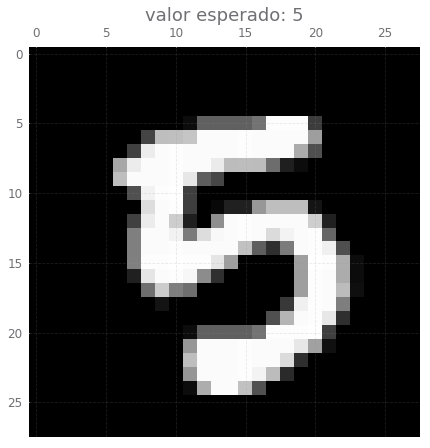

In [4]:
figsize(7, 7)
n = 554
matshow(dataset[n][0].reshape(28, 28), cmap=cm.gray)
plt.title(f"valor esperado: {dataset[n][1]}")
dataset[n][0].shape

In [5]:
model = onnx.load("netconv.onnx")

print(onnx.helper.printable_graph(model.graph))

graph torch-jit-export (
  %input_1[FLOAT, 1x1x28x28]
) initializers (
  %learned_0[FLOAT, 8x1x5x5]
  %learned_1[FLOAT, 8]
  %learned_2[FLOAT, 256x128]
  %learned_3[FLOAT, 256]
  %learned_4[FLOAT, 256x256]
  %learned_5[FLOAT, 256]
  %learned_6[FLOAT, 10x256]
  %learned_7[FLOAT, 10]
) {
  %9 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [1, 1]](%input_1, %learned_0, %learned_1)
  %10 = Relu(%9)
  %11 = MaxPool[kernel_shape = [5, 5], pads = [0, 0, 0, 0], strides = [5, 5]](%10)
  %12 = Constant[value = <Scalar Tensor []>]()
  %13 = Shape(%11)
  %14 = Gather[axis = 0](%13, %12)
  %15 = Constant[value = <Scalar Tensor []>]()
  %16 = Unsqueeze[axes = [0]](%14)
  %17 = Unsqueeze[axes = [0]](%15)
  %18 = Concat[axis = 0](%16, %17)
  %19 = Reshape(%11, %18)
  %20 = Gemm[alpha = 1, beta = 1, transB = 1](%19, %learned_2, %learned_3)
  %21 = Gemm[alpha = 1, beta = 1, transB = 1](%20, %learned_4, %learned_5)
  %22 = Gemm[alpha = 1, beta = 1, transB = 1]

In [29]:
%%bash 

python3 /usr/lib/python3.7/site-packages/onnx/tools/net_drawer.py --input netconv.onnx --output convnet.dot

dot -Grankdir=LR -Tpng convnet.dot -o netconv.png
dot -Grankdir=TB -Tpng convnet.dot -o netconv_top-botton.png

![](netconv.png)

In [6]:
tf_model = tf_backend.prepare(model)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [7]:
%%time
out = tf_model.run(dataset[n][0])

CPU times: user 94 ms, sys: 10.2 ms, total: 104 ms
Wall time: 1.17 s


In [8]:
print(out)
print(f"previsão: {out.output.argmax()}")

Outputs(output=array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]], dtype=float32))
previsão: 0


In [9]:
cf_model = caffe2_backend.prepare(model)

In [20]:
%%time
# m = np.random.randint(6000)
out = cf_model.run(dataset[n][0])

CPU times: user 5.39 ms, sys: 139 µs, total: 5.53 ms
Wall time: 5.12 ms


In [11]:
print(out)
print(f"previsão: {out.output.argmax()}")

Outputs(output=array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]], dtype=float32))
previsão: 0


In [12]:
%%time
out = caffe2_backend.run_model(model, dataset[n][0])

CPU times: user 46.4 ms, sys: 212 µs, total: 46.6 ms
Wall time: 225 ms


In [13]:
print(out)
print(f"previsão: {out.output.argmax()}")

Outputs(output=array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]], dtype=float32))
previsão: 0


In [14]:
init_net, predict_net = caffe2_backend.Caffe2Backend.onnx_graph_to_caffe2_net(model)
p = caffe2_workspace.Predictor(init_net, predict_net)

In [16]:
%%time
out = p.run(dataset[n][0].reshape(1, 1, 1, 28, 28))

CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 1.2 ms


In [17]:
print(out)
print(f"previsão: {out[0].argmax()}")

[array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]], dtype=float32)]
previsão: 0


In [18]:
init_net.name, predict_net.name

('torch-jit-export_init', 'torch-jit-export_predict')

In [21]:
%%timeit
m = np.random.randint(6000)
out = tf_model.run(dataset[m][0])

55.3 ms ± 2.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
m = np.random.randint(6000)
out = cf_model.run(dataset[m][0])

683 µs ± 23.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [23]:
%%timeit
m = np.random.randint(6000)
out = caffe2_backend.run_model(model, dataset[m][0])

16.3 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
m = np.random.randint(6000)
out = p.run(dataset[m][0].reshape(1, 1, 1, 28, 28))

393 µs ± 26.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
